<a href="https://colab.research.google.com/github/daichisaito-cs/glasses_shape_classification/blob/main/glasses_shape_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reference

In [ ]:
# https://www.kaggle.com/datasets/zeyadkhalid/faceshape-processed/data
# https://www.kaggle.com/code/zeyadkhalid/face-shape-recognition-73-accuracy

# Setup

In [ ]:
# driveのマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q wandb

In [ ]:
import os

ROOT_PATH = '/content/drive/Shareddrives/inSane/Workspace/EyeJapan'
DATASET_PATH = os.path.join(ROOT_PATH, 'data/glasses_shape_dataset')

In [ ]:
!ls {DATASET_PATH}

boston	leaderboard.gsheet  oval  square  wellington


# Traning

In [ ]:
# @title WandB

import wandb

wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [58]:
# @title data_loader.py
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from transformers import CLIPModel, CLIPProcessor
import torch
from PIL import Image
import os
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, processor, transform=None):
        self.root_dir = root_dir
        self.processor = processor
        self.transform = transform  # 追加の変換がある場合
        self.classes = ['oval', 'wellington', 'square', 'boston']
        self.class_to_idx = {cls.lower(): idx for idx, cls in enumerate(self.classes)}

        self.images = []
        self.labels = []

        for class_name in self.classes:
            class_dir = os.path.join(self.root_dir, class_name)
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.endswith(('.jpg', '.jpeg', '.png')):
                        self.images.append(os.path.join(class_dir, img_name))
                        self.labels.append(self.class_to_idx[class_name.lower()])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')

        # CLIPの前処理
        processed = self.processor(
            images=image,
            return_tensors="pt",
            do_rescale=True
        )
        image_tensor = processed['pixel_values'].squeeze(0)

        # 追加の変換がある場合は適用
        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, self.labels[idx]

def create_data_loaders(data_dir, processor, batch_size=32, train_split=0.8, valid_split=0.1):
    """データセットを train/valid/test に分割してデータローダーを作成する関数"""
    # 全データセットを読み込む
    full_dataset = CustomImageDataset(data_dir, processor)

    # ラベルを numpy 配列として取得
    labels = np.array([label for _, label in full_dataset])

    # まずトレーニングデータとその他(valid + test)に分割
    sss_train = StratifiedShuffleSplit(n_splits=1, train_size=train_split, random_state=42)
    train_idx, temp_idx = next(sss_train.split(np.zeros(len(labels)), labels))

    # 残りのデータをvalidとtestに分割
    temp_labels = labels[temp_idx]
    valid_ratio = valid_split / (1 - train_split)  # 残りの中でのvalid比率を計算
    sss_valid = StratifiedShuffleSplit(n_splits=1, train_size=valid_ratio, random_state=42)
    valid_idx_temp, test_idx_temp = next(sss_valid.split(np.zeros(len(temp_labels)), temp_labels))

    # インデックスを元のデータセットに合わせて調整
    valid_idx = temp_idx[valid_idx_temp]
    test_idx = temp_idx[test_idx_temp]

    # Subset作成
    train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
    valid_dataset = torch.utils.data.Subset(full_dataset, valid_idx)
    test_dataset = torch.utils.data.Subset(full_dataset, test_idx)

    print("Train set:")
    print_class_distribution(train_dataset)
    print("\nValidation set:")
    print_class_distribution(valid_dataset)
    print("\nTest set:")
    print_class_distribution(test_dataset)

    # データローダーの作成
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, valid_loader, test_loader

def print_class_distribution(dataset):
    labels = [label for _, label in dataset]
    unique, counts = np.unique(labels, return_counts=True)
    dist = dict(zip(unique, counts))
    print("Class distribution:", dist)
    print("Total samples:", sum(counts))

In [56]:
# @title utils.py

import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

def predict_one_shot(model, image_path, processor, device='cuda'):
    """1枚の画像に対して予測を行う関数"""
    # モデルを評価モードに
    model.eval()

    try:
        image = Image.open(image_path).convert('RGB')

        # CLIPプロセッサーで画像を処理
        processed = processor(
            images=image,
            return_tensors="pt",
            do_rescale=True
        )

        # 画像をデバイスに送る
        image_tensor = processed['pixel_values'].to(device)

        # 予測
        with torch.no_grad():
            outputs = model(image_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)

            # 最も確率の高いクラスとその確率を取得
            prob, predicted = torch.max(probabilities, 1)

            # クラス名を取得
            class_names = model.class_names
            predicted_class = class_names[predicted.item()]
            confidence = prob.item()

            # すべてのクラスの確率を辞書に格納
            all_probabilities = {
                class_name: round(prob.item() * 100, 2)
                for class_name, prob in zip(class_names, probabilities[0].cpu().numpy())
            }

            return {
                'predicted_class': predicted_class,
                'confidence': round(confidence * 100, 2),
                'all_probabilities': all_probabilities
            }

    except Exception as e:
        return {
            'error': str(e)
        }

def load_model(model, checkpoint_path, device='cuda'):
    """保存されたモデルをロードする関数"""
    # モデルの初期化

    # チェックポイントの読み込み
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # モデルの重みをロード
    model.load_state_dict(checkpoint['model_state_dict'])

    # デバイスに移動
    model = model.to(device)

    # 評価モードに設定
    model.eval()

    print(f"Loaded model from epoch {checkpoint['epoch']+1} with validation accuracy: {checkpoint['val_acc']:.2f}%")

    return model

# モデルのパラメータ数を表示
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# シード固定
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

In [53]:
# @title model.py

import torch.nn as nn
from transformers import CLIPModel

class ShapeClassifierBase(nn.Module):
    def __init__(self, class_names, num_classes, dropout_rate=0.2):
        super().__init__()
        self.class_names = class_names
        self.clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            # 出力層
            nn.Linear(128, num_classes)
        )

        # CLIPのパラメータを凍結
        for param in self.clip.parameters():
            param.requires_grad = False

    def forward(self, x):
        features = self.clip.get_image_features(x)
        outputs = self.classifier(features)
        return outputs

class GlassesClassifier(ShapeClassifierBase):
    def __init__(self, num_classes=4, dropout_rate=0.3):
        glass_classes = ['oval', 'wellington', 'square', 'boston']
        super().__init__(glass_classes, num_classes, dropout_rate)

# class FaceClassifier(ShapeClassifierBase):
#     def __init__(self, num_classes=4):
#         face_classes = ['square', 'oblong', 'round', 'heart']
#         super().__init__(face_classes, num_classes)

# class GlassesDetector(ShapeClassifierBase):
#     def __init__(self):
#         glass_detection_classes = ['wearing_glasses', 'no_glasses']
#         super().__init__(glass_detection_classes, num_classes=2)

In [25]:
# @title train.py

from tqdm import tqdm

def train_model(model, train_loader, optimizer, criterion, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # (images, labels) のみを受け取るように修正
    for batch_idx, (images, labels) in tqdm(
        enumerate(train_loader),
        total=len(train_loader),
        desc=f"Epoch {epoch}"
    ):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        if (batch_idx + 1) % 10 == 0:
            wandb.log({
                "batch": batch_idx + 1,
                "batch_loss": loss.item(),
                "batch_acc": 100. * correct / total
            })

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

In [26]:
# @title validate.py

def validate_model(model, valid_loader, criterion, device, epoch, split="valid"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        # (images, labels) のみを受け取るように修正
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(valid_loader)
    val_acc = 100. * correct / total

    wandb.log({
        f"{split}_loss": val_loss,
        f"{split}_accuracy": val_acc,
        "epoch": epoch
    })

    return val_loss, val_acc

In [27]:
# @title test.py

def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        # (images, labels) のみを受け取るように修正
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    accuracy = 100. * correct / total

    wandb.log({
        "confusion_matrix": wandb.plot.confusion_matrix(
            probs=None,
            y_true=all_targets,
            preds=all_predictions
        )
    })

    return accuracy, all_predictions, all_targets

In [28]:
# @title early_stopping.py

class EarlyStopping:
    """Early Stoppingを制御するクラス"""
    def __init__(self, patience=7, min_delta=0, verbose=True):
        self.patience = patience  # 改善が見られるのを待つエポック数
        self.min_delta = min_delta  # 改善とみなす最小変化量
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

index: 163
index: 28
index: 6
index: 189
=== Dataset Analysis ===

Total samples: 925

Class distribution:
oval: 167 (18.1%)
wellington: 250 (27.0%)
square: 255 (27.6%)
boston: 253 (27.4%)


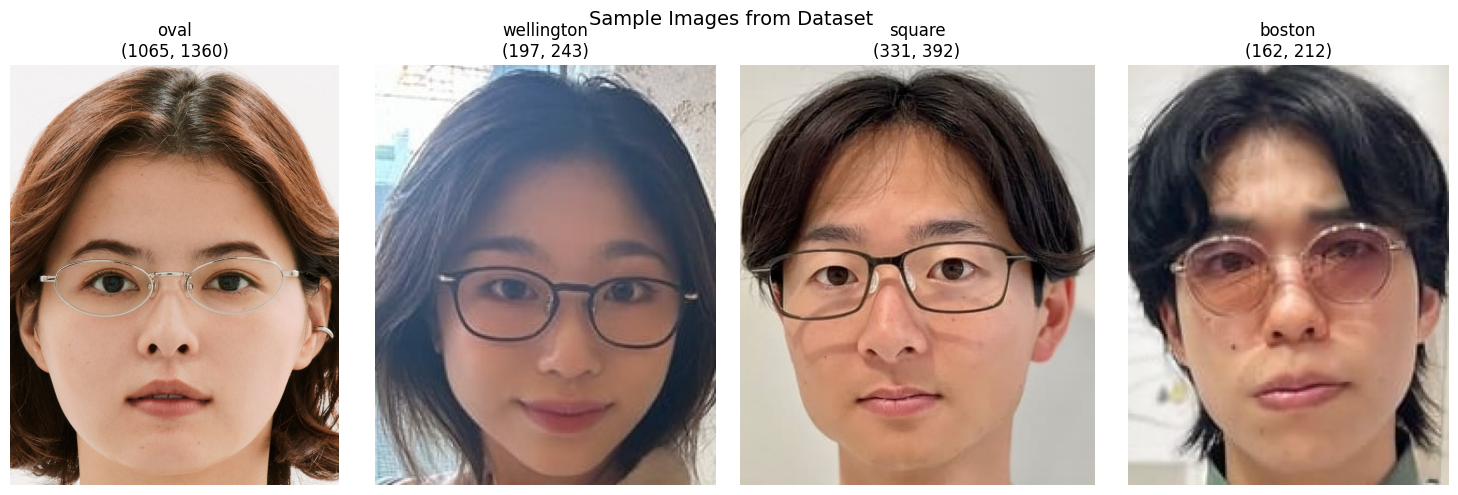

In [57]:
# @title dataset_info.py
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def analyze_dataset(data_dir):
    """データセットの情報を分析して表示する関数"""
    set_seed(42)
    classes = ['oval', 'wellington', 'square', 'boston']
    dataset_info = {}

    # データセット全体の情報を収集
    class_counts = {}
    total_samples = 0
    sample_paths = {}  # 各クラスのサンプル画像パスを保存

    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: {class_dir} does not exist")
            class_counts[class_name] = 0
            continue

        # 画像ファイルをカウント
        images = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        class_counts[class_name] = len(images)
        total_samples += len(images)

        # ランダムな選択を固定
        if images:
            random_idx = random.randint(0, len(images) - 1)
            print(f"index: {random_idx}")
            sample_paths[class_name] = os.path.join(class_dir, images[random_idx])

    dataset_info = {
        'total': total_samples,
        'class_counts': class_counts,
        'sample_paths': sample_paths
    }

    # 情報の表示
    print("=== Dataset Analysis ===")
    print(f"\nTotal samples: {dataset_info['total']}")
    print("\nClass distribution:")
    for class_name, count in dataset_info['class_counts'].items():
        percentage = (count / dataset_info['total'] * 100) if dataset_info['total'] > 0 else 0
        print(f"{class_name}: {count} ({percentage:.1f}%)")

    # サンプル画像の表示
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle("Sample Images from Dataset", fontsize=14)

    for i, class_name in enumerate(classes, 1):
        if class_name in dataset_info['sample_paths']:
            plt.subplot(1, 4, i)
            img_path = dataset_info['sample_paths'][class_name]
            img = Image.open(img_path)
            plt.imshow(img)
            plt.title(f"{class_name}\n{img.size}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

    return dataset_info

# データセットの分析を実行
dataset_info = analyze_dataset(DATASET_PATH)

In [59]:
# @title main.py

from datetime import datetime
import wandb
import pytz
from torch import optim
import torch.nn as nn
import os

def run_training(model, train_loader, valid_loader, test_loader,
                num_epochs, patience, lr, device='cuda'):
    """Early Stopping機能を追加した学習管理関数"""

    # 日本時間で現在の時刻を取得
    jst = pytz.timezone('Asia/Tokyo')
    current_time = datetime.now(jst).strftime("%Y-%m-%d_%H-%M-%S")

    # チェックポイント保存用のディレクトリ作成
    base_checkpoint_dir = 'checkpoints'
    os.makedirs(base_checkpoint_dir, exist_ok=True)

    # current_time のサブディレクトリを作成
    save_dir = os.path.join(base_checkpoint_dir, current_time)
    os.makedirs(save_dir, exist_ok=True)

    wandb.init(
        project="glasses-shape-classification",
        name=f"run-{current_time}",
        config={
            "architecture": model.__class__.__name__,
            "dataset": "glasses_shapes",
            "epochs": num_epochs,
            "batch_size": train_loader.batch_size,
            "optimizer": "Adam",
            "learning_rate": lr,
            "early_stopping_patience": patience
        }
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=lr)
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    # best_val_acc = 0
    best_val_loss = float('inf')
    best_model_path = None

    for epoch in range(num_epochs):
        # 学習
        train_loss, train_acc = train_model(
            model, train_loader, optimizer, criterion, device, epoch
        )

        # 検証
        val_loss, val_acc = validate_model(
            model, valid_loader, criterion, device, epoch
        )

        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # モデルの保存
        # if val_acc > best_val_acc:
        #     best_val_acc = val_acc
        if val_loss < best_val_loss:
            best_val_loss = val_loss

            # 以前のベストモデルを削除
            if best_model_path and os.path.exists(best_model_path):
                os.remove(best_model_path)

            # 新しいベストモデルを保存
            best_model_path = os.path.join(save_dir, f'best_model_epoch_{epoch+1}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc,
            }, best_model_path)

            # wandbにモデルをアップロード
            artifact = wandb.Artifact(
                name=f'best-model-epoch-{epoch+1}',
                type='model',
                description=f'Best model checkpoint from epoch {epoch+1}'
            )
            artifact.add_file(best_model_path)
            wandb.log_artifact(artifact)

            print(f'Model saved to {best_model_path} with validation accuracy: {val_acc:.2f}%')

        # Early Stoppingの判定
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

    # 最良のモデルを読み込む
    if best_model_path:
        checkpoint = torch.load(best_model_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f'Loaded best model from epoch {checkpoint["epoch"]+1} '
              f'with validation accuracy: {checkpoint["val_acc"]:.2f}%')

    # テストデータで評価
    test_acc, predictions, targets = test_model(model, test_loader, device)
    print(f'\nFinal Test Accuracy: {test_acc:.2f}%')

    wandb.finish()
    return model, best_model_path, save_dir  # save_dirも返すように変更

set_seed(42)

# モデルとデータの準備
model = GlassesClassifier(num_classes=4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# プロセッサーの取得
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# データローダーの作成
train_loader, valid_loader, test_loader = create_data_loaders(
    DATASET_PATH,
    processor=processor,
    batch_size=32
)

# 学習の実行（Early Stoppingのパラメータを指定可能）
trained_model, best_model_path, checkpoint_dir = run_training(
    model,
    train_loader,
    valid_loader,
    test_loader,
    num_epochs=200,
    patience=7,
    lr=0.0001,
    device=device
)

print(f"Checkpoints saved in: {checkpoint_dir}")

Train set:
Class distribution: {0: 134, 1: 200, 2: 204, 3: 202}
Total samples: 740

Validation set:
Class distribution: {0: 17, 1: 25, 2: 25, 3: 25}
Total samples: 92

Test set:
Class distribution: {0: 16, 1: 25, 2: 26, 3: 26}
Total samples: 93


Epoch 0: 100%|██████████| 24/24 [00:10<00:00,  2.22it/s]



Epoch 1/200:
Train Loss: 1.4385, Train Acc: 26.76%
Val Loss: 1.3789, Val Acc: 29.35%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_1.pth with validation accuracy: 29.35%


Epoch 1: 100%|██████████| 24/24 [00:14<00:00,  1.61it/s]



Epoch 2/200:
Train Loss: 1.3526, Train Acc: 33.92%
Val Loss: 1.3419, Val Acc: 34.78%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_2.pth with validation accuracy: 34.78%


Epoch 2: 100%|██████████| 24/24 [00:14<00:00,  1.70it/s]



Epoch 3/200:
Train Loss: 1.2718, Train Acc: 41.62%
Val Loss: 1.2893, Val Acc: 40.22%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_3.pth with validation accuracy: 40.22%


Epoch 3: 100%|██████████| 24/24 [00:14<00:00,  1.69it/s]



Epoch 4/200:
Train Loss: 1.2037, Train Acc: 46.49%
Val Loss: 1.2570, Val Acc: 44.57%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_4.pth with validation accuracy: 44.57%


Epoch 4: 100%|██████████| 24/24 [00:13<00:00,  1.72it/s]



Epoch 5/200:
Train Loss: 1.1725, Train Acc: 47.97%
Val Loss: 1.2327, Val Acc: 44.57%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_5.pth with validation accuracy: 44.57%


Epoch 5: 100%|██████████| 24/24 [00:14<00:00,  1.70it/s]



Epoch 6/200:
Train Loss: 1.1072, Train Acc: 54.05%
Val Loss: 1.2186, Val Acc: 46.74%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_6.pth with validation accuracy: 46.74%


Epoch 6: 100%|██████████| 24/24 [00:13<00:00,  1.76it/s]



Epoch 7/200:
Train Loss: 1.1055, Train Acc: 55.14%
Val Loss: 1.1916, Val Acc: 50.00%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_7.pth with validation accuracy: 50.00%


Epoch 7: 100%|██████████| 24/24 [00:14<00:00,  1.66it/s]



Epoch 8/200:
Train Loss: 1.0689, Train Acc: 59.59%
Val Loss: 1.1708, Val Acc: 51.09%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_8.pth with validation accuracy: 51.09%


Epoch 8: 100%|██████████| 24/24 [00:14<00:00,  1.61it/s]



Epoch 9/200:
Train Loss: 1.0372, Train Acc: 60.14%
Val Loss: 1.1557, Val Acc: 53.26%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_9.pth with validation accuracy: 53.26%


Epoch 9: 100%|██████████| 24/24 [00:13<00:00,  1.73it/s]



Epoch 10/200:
Train Loss: 0.9871, Train Acc: 63.92%
Val Loss: 1.1431, Val Acc: 52.17%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_10.pth with validation accuracy: 52.17%


Epoch 10: 100%|██████████| 24/24 [00:13<00:00,  1.74it/s]



Epoch 11/200:
Train Loss: 0.9678, Train Acc: 64.73%
Val Loss: 1.1417, Val Acc: 52.17%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_11.pth with validation accuracy: 52.17%


Epoch 11: 100%|██████████| 24/24 [00:13<00:00,  1.72it/s]



Epoch 12/200:
Train Loss: 0.9531, Train Acc: 68.92%
Val Loss: 1.1252, Val Acc: 51.09%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_12.pth with validation accuracy: 51.09%


Epoch 12: 100%|██████████| 24/24 [00:14<00:00,  1.65it/s]



Epoch 13/200:
Train Loss: 0.9095, Train Acc: 68.92%
Val Loss: 1.1172, Val Acc: 52.17%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_13.pth with validation accuracy: 52.17%


Epoch 13: 100%|██████████| 24/24 [00:13<00:00,  1.72it/s]



Epoch 14/200:
Train Loss: 0.8923, Train Acc: 68.11%
Val Loss: 1.1091, Val Acc: 47.83%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_14.pth with validation accuracy: 47.83%


Epoch 14: 100%|██████████| 24/24 [00:14<00:00,  1.65it/s]



Epoch 15/200:
Train Loss: 0.8932, Train Acc: 69.19%
Val Loss: 1.0935, Val Acc: 51.09%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_15.pth with validation accuracy: 51.09%


Epoch 15: 100%|██████████| 24/24 [00:14<00:00,  1.64it/s]



Epoch 16/200:
Train Loss: 0.8698, Train Acc: 70.68%
Val Loss: 1.0845, Val Acc: 48.91%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_16.pth with validation accuracy: 48.91%


Epoch 16: 100%|██████████| 24/24 [00:15<00:00,  1.60it/s]



Epoch 17/200:
Train Loss: 0.8498, Train Acc: 71.22%
Val Loss: 1.0776, Val Acc: 54.35%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_17.pth with validation accuracy: 54.35%


Epoch 17: 100%|██████████| 24/24 [00:15<00:00,  1.55it/s]



Epoch 18/200:
Train Loss: 0.8168, Train Acc: 70.95%
Val Loss: 1.0622, Val Acc: 55.43%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_18.pth with validation accuracy: 55.43%


Epoch 18: 100%|██████████| 24/24 [00:14<00:00,  1.66it/s]



Epoch 19/200:
Train Loss: 0.7933, Train Acc: 72.16%
Val Loss: 1.0531, Val Acc: 50.00%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_19.pth with validation accuracy: 50.00%


Epoch 19: 100%|██████████| 24/24 [00:14<00:00,  1.65it/s]



Epoch 20/200:
Train Loss: 0.7881, Train Acc: 73.65%
Val Loss: 1.0461, Val Acc: 54.35%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_20.pth with validation accuracy: 54.35%


Epoch 20: 100%|██████████| 24/24 [00:16<00:00,  1.49it/s]



Epoch 21/200:
Train Loss: 0.7577, Train Acc: 76.08%
Val Loss: 1.0355, Val Acc: 54.35%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_21.pth with validation accuracy: 54.35%


Epoch 21: 100%|██████████| 24/24 [00:15<00:00,  1.52it/s]



Epoch 22/200:
Train Loss: 0.7514, Train Acc: 75.54%
Val Loss: 1.0276, Val Acc: 55.43%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_22.pth with validation accuracy: 55.43%


Epoch 22: 100%|██████████| 24/24 [00:15<00:00,  1.54it/s]



Epoch 23/200:
Train Loss: 0.7211, Train Acc: 77.57%
Val Loss: 1.0267, Val Acc: 58.70%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_23.pth with validation accuracy: 58.70%


Epoch 23: 100%|██████████| 24/24 [00:15<00:00,  1.54it/s]



Epoch 24/200:
Train Loss: 0.7375, Train Acc: 76.62%
Val Loss: 1.0176, Val Acc: 57.61%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_24.pth with validation accuracy: 57.61%


Epoch 24: 100%|██████████| 24/24 [00:16<00:00,  1.48it/s]



Epoch 25/200:
Train Loss: 0.7095, Train Acc: 79.05%
Val Loss: 1.0155, Val Acc: 57.61%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_25.pth with validation accuracy: 57.61%


Epoch 25: 100%|██████████| 24/24 [00:14<00:00,  1.61it/s]



Epoch 26/200:
Train Loss: 0.7029, Train Acc: 77.43%
Val Loss: 1.0125, Val Acc: 57.61%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_26.pth with validation accuracy: 57.61%


Epoch 26: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]



Epoch 27/200:
Train Loss: 0.6959, Train Acc: 77.57%
Val Loss: 1.0010, Val Acc: 59.78%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_27.pth with validation accuracy: 59.78%


Epoch 27: 100%|██████████| 24/24 [00:13<00:00,  1.72it/s]



Epoch 28/200:
Train Loss: 0.6727, Train Acc: 79.46%
Val Loss: 0.9958, Val Acc: 61.96%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_28.pth with validation accuracy: 61.96%


Epoch 28: 100%|██████████| 24/24 [00:14<00:00,  1.64it/s]



Epoch 29/200:
Train Loss: 0.6630, Train Acc: 81.08%
Val Loss: 0.9891, Val Acc: 58.70%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_29.pth with validation accuracy: 58.70%


Epoch 29: 100%|██████████| 24/24 [00:14<00:00,  1.68it/s]



Epoch 30/200:
Train Loss: 0.6387, Train Acc: 80.27%
Val Loss: 0.9824, Val Acc: 58.70%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_30.pth with validation accuracy: 58.70%


Epoch 30: 100%|██████████| 24/24 [00:14<00:00,  1.70it/s]



Epoch 31/200:
Train Loss: 0.6060, Train Acc: 80.81%
Val Loss: 0.9808, Val Acc: 57.61%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_31.pth with validation accuracy: 57.61%


Epoch 31: 100%|██████████| 24/24 [00:13<00:00,  1.75it/s]



Epoch 32/200:
Train Loss: 0.6085, Train Acc: 82.97%
Val Loss: 0.9818, Val Acc: 58.70%
EarlyStopping counter: 1 out of 7


Epoch 32: 100%|██████████| 24/24 [00:11<00:00,  2.09it/s]



Epoch 33/200:
Train Loss: 0.6388, Train Acc: 83.24%
Val Loss: 0.9727, Val Acc: 55.43%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_33.pth with validation accuracy: 55.43%


Epoch 33: 100%|██████████| 24/24 [00:14<00:00,  1.62it/s]



Epoch 34/200:
Train Loss: 0.6019, Train Acc: 81.08%
Val Loss: 0.9831, Val Acc: 55.43%
EarlyStopping counter: 1 out of 7


Epoch 34: 100%|██████████| 24/24 [00:11<00:00,  2.12it/s]



Epoch 35/200:
Train Loss: 0.5842, Train Acc: 84.05%
Val Loss: 0.9767, Val Acc: 54.35%
EarlyStopping counter: 2 out of 7


Epoch 35: 100%|██████████| 24/24 [00:11<00:00,  2.12it/s]



Epoch 36/200:
Train Loss: 0.5969, Train Acc: 83.11%
Val Loss: 0.9725, Val Acc: 58.70%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_36.pth with validation accuracy: 58.70%


Epoch 36: 100%|██████████| 24/24 [00:13<00:00,  1.75it/s]



Epoch 37/200:
Train Loss: 0.5621, Train Acc: 84.32%
Val Loss: 0.9611, Val Acc: 57.61%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_37.pth with validation accuracy: 57.61%


Epoch 37: 100%|██████████| 24/24 [00:14<00:00,  1.61it/s]



Epoch 38/200:
Train Loss: 0.5646, Train Acc: 84.05%
Val Loss: 0.9698, Val Acc: 56.52%
EarlyStopping counter: 1 out of 7


Epoch 38: 100%|██████████| 24/24 [00:11<00:00,  2.09it/s]



Epoch 39/200:
Train Loss: 0.5324, Train Acc: 86.49%
Val Loss: 0.9775, Val Acc: 56.52%
EarlyStopping counter: 2 out of 7


Epoch 39: 100%|██████████| 24/24 [00:11<00:00,  2.13it/s]



Epoch 40/200:
Train Loss: 0.5453, Train Acc: 86.35%
Val Loss: 0.9586, Val Acc: 54.35%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_40.pth with validation accuracy: 54.35%


Epoch 40: 100%|██████████| 24/24 [00:13<00:00,  1.77it/s]



Epoch 41/200:
Train Loss: 0.5493, Train Acc: 84.59%
Val Loss: 0.9523, Val Acc: 56.52%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_41.pth with validation accuracy: 56.52%


Epoch 41: 100%|██████████| 24/24 [00:14<00:00,  1.62it/s]



Epoch 42/200:
Train Loss: 0.5175, Train Acc: 87.16%
Val Loss: 0.9586, Val Acc: 56.52%
EarlyStopping counter: 1 out of 7


Epoch 42: 100%|██████████| 24/24 [00:11<00:00,  2.10it/s]



Epoch 43/200:
Train Loss: 0.5330, Train Acc: 85.54%
Val Loss: 0.9601, Val Acc: 59.78%
EarlyStopping counter: 2 out of 7


Epoch 43: 100%|██████████| 24/24 [00:11<00:00,  2.12it/s]



Epoch 44/200:
Train Loss: 0.5020, Train Acc: 87.03%
Val Loss: 0.9565, Val Acc: 57.61%
EarlyStopping counter: 3 out of 7


Epoch 44: 100%|██████████| 24/24 [00:11<00:00,  2.03it/s]



Epoch 45/200:
Train Loss: 0.4765, Train Acc: 88.92%
Val Loss: 0.9468, Val Acc: 56.52%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_45.pth with validation accuracy: 56.52%


Epoch 45: 100%|██████████| 24/24 [00:15<00:00,  1.55it/s]



Epoch 46/200:
Train Loss: 0.4558, Train Acc: 88.65%
Val Loss: 0.9455, Val Acc: 56.52%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_46.pth with validation accuracy: 56.52%


Epoch 46: 100%|██████████| 24/24 [00:14<00:00,  1.60it/s]



Epoch 47/200:
Train Loss: 0.4557, Train Acc: 89.19%
Val Loss: 0.9418, Val Acc: 56.52%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_47.pth with validation accuracy: 56.52%


Epoch 47: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]



Epoch 48/200:
Train Loss: 0.4732, Train Acc: 88.51%
Val Loss: 0.9425, Val Acc: 55.43%
EarlyStopping counter: 1 out of 7


Epoch 48: 100%|██████████| 24/24 [00:11<00:00,  2.12it/s]



Epoch 49/200:
Train Loss: 0.4414, Train Acc: 89.19%
Val Loss: 0.9347, Val Acc: 57.61%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_49.pth with validation accuracy: 57.61%


Epoch 49: 100%|██████████| 24/24 [00:13<00:00,  1.84it/s]



Epoch 50/200:
Train Loss: 0.4429, Train Acc: 89.86%
Val Loss: 0.9306, Val Acc: 56.52%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_50.pth with validation accuracy: 56.52%


Epoch 50: 100%|██████████| 24/24 [00:15<00:00,  1.57it/s]



Epoch 51/200:
Train Loss: 0.4545, Train Acc: 89.32%
Val Loss: 0.9307, Val Acc: 58.70%
EarlyStopping counter: 1 out of 7


Epoch 51: 100%|██████████| 24/24 [00:11<00:00,  2.09it/s]



Epoch 52/200:
Train Loss: 0.4501, Train Acc: 90.41%
Val Loss: 0.9354, Val Acc: 57.61%
EarlyStopping counter: 2 out of 7


Epoch 52: 100%|██████████| 24/24 [00:11<00:00,  2.14it/s]



Epoch 53/200:
Train Loss: 0.4318, Train Acc: 89.86%
Val Loss: 0.9355, Val Acc: 58.70%
EarlyStopping counter: 3 out of 7


Epoch 53: 100%|██████████| 24/24 [00:11<00:00,  2.10it/s]



Epoch 54/200:
Train Loss: 0.4290, Train Acc: 90.41%
Val Loss: 0.9449, Val Acc: 58.70%
EarlyStopping counter: 4 out of 7


Epoch 54: 100%|██████████| 24/24 [00:11<00:00,  2.07it/s]



Epoch 55/200:
Train Loss: 0.4029, Train Acc: 92.03%
Val Loss: 0.9415, Val Acc: 57.61%
EarlyStopping counter: 5 out of 7


Epoch 55: 100%|██████████| 24/24 [00:11<00:00,  2.09it/s]



Epoch 56/200:
Train Loss: 0.4198, Train Acc: 90.27%
Val Loss: 0.9242, Val Acc: 56.52%
Model saved to checkpoints/2024-11-13_07-55-15/best_model_epoch_56.pth with validation accuracy: 56.52%


Epoch 56: 100%|██████████| 24/24 [00:13<00:00,  1.78it/s]



Epoch 57/200:
Train Loss: 0.4146, Train Acc: 91.76%
Val Loss: 0.9287, Val Acc: 56.52%
EarlyStopping counter: 1 out of 7


Epoch 57: 100%|██████████| 24/24 [00:11<00:00,  2.12it/s]



Epoch 58/200:
Train Loss: 0.3683, Train Acc: 92.43%
Val Loss: 0.9252, Val Acc: 58.70%
EarlyStopping counter: 2 out of 7


Epoch 58: 100%|██████████| 24/24 [00:11<00:00,  2.06it/s]



Epoch 59/200:
Train Loss: 0.4342, Train Acc: 90.54%
Val Loss: 0.9373, Val Acc: 56.52%
EarlyStopping counter: 3 out of 7


Epoch 59: 100%|██████████| 24/24 [00:11<00:00,  2.13it/s]



Epoch 60/200:
Train Loss: 0.3935, Train Acc: 92.30%
Val Loss: 0.9319, Val Acc: 58.70%
EarlyStopping counter: 4 out of 7


Epoch 60: 100%|██████████| 24/24 [00:11<00:00,  2.13it/s]



Epoch 61/200:
Train Loss: 0.3907, Train Acc: 92.03%
Val Loss: 0.9293, Val Acc: 58.70%
EarlyStopping counter: 5 out of 7


Epoch 61: 100%|██████████| 24/24 [00:11<00:00,  2.11it/s]



Epoch 62/200:
Train Loss: 0.3746, Train Acc: 92.70%
Val Loss: 0.9373, Val Acc: 58.70%
EarlyStopping counter: 6 out of 7


Epoch 62: 100%|██████████| 24/24 [00:11<00:00,  2.08it/s]



Epoch 63/200:
Train Loss: 0.3675, Train Acc: 91.08%
Val Loss: 0.9453, Val Acc: 57.61%
EarlyStopping counter: 7 out of 7
Early stopping triggered at epoch 63


<ipython-input-59-fc511d39574f>:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path)


Loaded best model from epoch 56 with validation accuracy: 56.52%

Final Test Accuracy: 58.06%


batch,██▁█▁█▁███▁█▁▁█▁▁██▁▁█▁▁█▁█▁███▁██▁█▁███
batch_acc,▁▂▂▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇██▇▇███████▇
batch_loss,▇█▇▇▇▇▅▆▆▅▄▆▄▄▅▅▄▄▄▃▄▄▃▃▃▃▂▃▂▃▂▂▂▂▂▂▁▃▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇██
valid_accuracy,▁▂▃▄▅▆▆▆▅▆▅▆▆▇▇▇▇██▇▇▇▇▆▇▇▆▇▇█▇▇▇▇▇▇▇▇▇▇
valid_loss,█▇▆▆▆▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
batch,20
batch_acc,90.625
batch_loss,0.29008
epoch,62
valid_accuracy,57.6087


Checkpoints saved in: checkpoints/2024-11-13_07-55-15


In [17]:
# wandb.finish()

In [60]:
print(best_model_path)

checkpoints/2024-11-13_07-55-15/best_model_epoch_56.pth


In [61]:
!cp {best_model_path} {ROOT_PATH}/checkpoints/glasses_shape/{best_model_path.split('/')[-2]}.pth

In [62]:
# @title predict_one_shot.py

from transformers import CLIPProcessor

# モデルとプロセッサーの準備
model = GlassesClassifier(num_classes=4)
# モデルのロード
model = load_model(model, best_model_path, device=device)

# プロセッサーの準備
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# 画像の予測
image_path = os.path.join(ROOT_PATH, 'data/test_images/square.jpg')
result = predict_one_shot(model, image_path, processor, device)

if 'error' in result:
    print(f"Error: {result['error']}")
else:
    print(f"Predicted class: {result['predicted_class']}")
    print(f"Confidence: {result['confidence']}%")
    print("\nAll class probabilities:")
    for class_name, prob in result['all_probabilities'].items():
        print(f"{class_name}: {prob}%")

<ipython-input-56-7edd74731301>:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loaded model from epoch 56 with validation accuracy: 56.52%
Predicted class: wellington
Confidence: 43.34%

All class probabilities:
oval: 19.0%
wellington: 43.34%
square: 36.02%
boston: 1.64%
